In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
plt.rcParams["font.family"] = "sans-serif"
sns.set_palette("dark")
sns.set_context("talk")

%matplotlib

import numpy as np
from scipy.linalg import expm

from IPython.display import HTML, display, SVG

import pydot
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder, BasicVector,
                        Parser, Saturation, Simulator, PlanarSceneGraphVisualizer, 
                        LinearQuadraticRegulator, AbstractValue, MeshcatVisualizer, 
                        StartMeshcat, WrapToSystem, SceneGraph, DiscreteTimeLinearQuadraticRegulator)    

from pydrake.systems.primitives import LogVectorOutput, ConstantVectorSource

from pydrake.systems.framework import LeafSystem
from pydrake.multibody import inverse_kinematics
from pydrake.multibody import plant as plnt
from pydrake.multibody import math as m
from pydrake.multibody.tree import MultibodyForces, UniformGravityFieldElement, LinearBushingRollPitchYaw

from pydrake.multibody.plant import ContactResults
from pydrake.autodiffutils import AutoDiffXd, InitializeAutoDiff, ExtractGradient
from underactuated.meshcat_cpp_utils import MeshcatSliders, MeshcatJointSliders
from Custom_LeafSystems import *

from tqdm import tqdm as tqdm

from Linearize import getGradients

from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve

# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

Using matplotlib backend: TkAgg


INFO:drake:Meshcat listening for connections at http://localhost:7000


In [2]:
time_step = 1/1000.
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=time_step)
body = Parser(plant).AddModelFromFile("Double_Leg/Double_Leg_Extra_DOF_free.urdf")

# Connect left and right hip via a bushing joint to form quasi closed loop robot
# Fixed joint using penalty method 3 for stiffness and method 2 for damping

# Get both bodies to connect
# hip_left = plant.GetBodyByName("middle")
# hip_right = plant.GetBodyByName("middle_dummy_R")

q_max = 0.1 * np.pi / 180  # 0.1 degrees maximum deviation
x_max = 1E-4  # 0.1 mm max deviation

M_max = 10   # Maximum estimated moment on the joint
F_max = 10   # Maximum estimated force on the joint

settling_time = 0.2 # Settling time in seconds
settling_ratio = 0.01   # Settling ratios must be either 0.01, 0.02, 0.05 or 0.10

def natural_freq(settling_ratio):
    return {"0.01": 6.64/settling_time,
            "0.02": 5.83/settling_time,
            "0.05": 4.74/settling_time,
            "0.10": 3.89/settling_time}[str(settling_ratio)]

w_n = natural_freq(settling_ratio)
zeta = 1. 

# TODO: Support numbers with mathematics
# Determine torque stiffness
k_theta = M_max / q_max * np.ones(3)

# Determine force stiffness
k_x = F_max / x_max * np.ones(3)

# Determine torque damping
d_theta = 2*zeta*k_theta / w_n

# Determine force damping
d_x = 2*zeta*k_x / w_n

# Create bushing element
# bushing = plant.AddForceElement(LinearBushingRollPitchYaw(
#             frameA=hip_left.body_frame(),
#             frameC=hip_right.body_frame(),
#             torque_stiffness_constants=k_theta,
#             torque_damping_constants=d_theta,
#             force_stiffness_constants=k_x,
#             force_damping_constants=d_x))

plant.Finalize()

meshcat.Delete()
vis = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

context = plant.CreateDefaultContext()
x0 = np.zeros(plant.num_continuous_states())
context.get_mutable_continuous_state_vector().SetFromVector(x0)
CoM_0 = plant.CalcCenterOfMassPositionInWorld(context)

plant.get_actuation_input_port().FixValue(context, np.zeros(plant.num_actuators()))

h_G = plant.CalcSpatialMomentumInWorldAboutPoint(context, CoM_0)
print(h_G.rotational(), h_G.translational())


# print(dir(plant))

# display(SVG(pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].create_svg()))

# generic_input = builder.AddSystem(ConstantVectorSource(np.zeros(plant.num_actuators())))

# diagram = builder.Build()
# display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

# def PoseOptimization():
#     context_diagram = diagram.CreateDefaultContext()
#     plant_context_from_diagram = diagram.GetSubsystemContext(plant, context_diagram)

#     sliders = MeshcatJointSliders(meshcat, plant, context_diagram)
#     sliders.Run(vis, context_diagram)
#     meshcat.DeleteAddedControls()
#     meshcat.Delete()

# PoseOptimization()

[0. 0. 0.] [0. 0. 0.]


In [3]:
# Optimization

plant_f = plant
context_f = plant_f.CreateDefaultContext()

plant_ad = plant.ToAutoDiffXd()
context_ad = plant_ad.CreateDefaultContext()

prog = MathematicalProgram()

pos = prog.NewContinuousVariables(plant.num_positions(), "positions")
vel = prog.NewContinuousVariables(plant.num_velocities(), "velocities")
acc = prog.NewContinuousVariables(plant.num_velocities(), "accelerations")
torques = prog.NewContinuousVariables(plant.num_actuators(), "torques")

B = plant.MakeActuationMatrix()

def getAcceleration(vars):

    split_at = [plant_f.num_actuators(), plant_f.num_actuators() + plant_f.num_velocities(), plant_f.num_actuators() + 2*plant_f.num_velocities()]
    tau, pos, vel, acc = np.split(vars, split_at)
    
    if tau.dtype == float:
        plant = plant_f
        context = context_f
    else:
        plant = plant_ad
        context = context_ad 

    plant.SetPositions(context, pos)
    plant.SetVelocities(context, vel)
    plant.get_actuation_input_port().FixValue(context, tau)

    # M, Cv, taug
    M = plant.CalcMassMatrixViaInverseDynamics(context)
    Cv = plant.CalcBiasTerm(context)
    taug = plant.CalcGravityGeneralizedForces(context)

    return M @ acc + Cv - taug - B @ tau


def CostCoM(q):

    if q.dtype == float:
        plant = plant_f
        context = context_f
    else:
        plant = plant_ad
        context = context_ad

    plant.SetPositions(context, q)
    CoM = plant.CalcCenterOfMassPositionInWorld(context)[0:2]

    return CoM.dot(CoM)


def getCoM(q):

    if q.dtype == float:
        plant = plant_f
        context = context_f
    else:
        plant = plant_ad
        context = context_ad

    plant.SetPositions(context, q)
    CoM = plant.CalcCenterOfMassPositionInWorld(context)[0:2]

    return CoM


def Inverse_Dyn(vars):
    accs = getAcceleration(vars)
    return accs.dot(accs)


vars = np.concatenate((torques, pos, vel, acc))

# Zero Acceleration
prog.AddConstraint(getAcceleration, lb=[0]*plant.num_velocities(), ub=[0]*plant.num_velocities(), vars=vars)

# Zero Velocity
for accs in acc: prog.AddConstraint(accs == 0)
for vels in vel: prog.AddConstraint(vels == 0)

prog.AddCost(Inverse_Dyn, vars=vars)
prog.AddCost(CostCoM, vars=pos)
# prog.AddCost(torques.dot(torques))

# Joint Angles between certain ranges

prog.AddConstraint(getCoM, lb=[0]*2, ub=[0]*2, vars=pos)

prog.AddConstraint(pos[0] >= 0.10), prog.AddConstraint(pos[0] <= np.pi/2)
# prog.AddConstraint(pos[1] == 0), prog.AddConstraint(pos[1] == 0)
# prog.AddConstraint(pos[2] >= -np.pi/2), prog.AddConstraint(pos[2] <= -0.25)
# prog.AddConstraint(pos[3] >= -np.pi/2), prog.AddConstraint(pos[3] <= np.pi/2)
# prog.AddConstraint(pos[4] == 0)

# Hip pitch more than 5 degrees
prog.AddConstraint(pos[1] <= -0.05*np.pi/180)
# prog.AddConstraint(pos[5] <= 0.5), prog.AddConstraint(pos[5] >= -0.5)

# prog.AddConstraint(pos[6] >= 0.25), prog.AddConstraint(pos[6] <= np.pi/2)
# prog.AddConstraint(pos[7] == 0), prog.AddConstraint(pos[7] == 0)
# prog.AddConstraint(pos[8] >= -np.pi/2), prog.AddConstraint(pos[8] <= -0.25)
# prog.AddConstraint(pos[9] >= -np.pi/2), prog.AddConstraint(pos[9] <= np.pi/2)
# prog.AddConstraint(pos[10] == 0)

# prog.AddConstraint(torques[0] == torques[4])
# prog.AddConstraint(torques[1] == torques[5])
# prog.AddConstraint(torques[2] == torques[6])

# prog.AddConstraint(pos[0] == pos[6])
# prog.AddConstraint(pos[1] == pos[7])
# prog.AddConstraint(pos[2] == pos[8])
# prog.AddConstraint(pos[3] == pos[9])
# prog.AddConstraint(pos[4] == pos[10])
# prog.AddConstraint(pos[5] == 0)

# Pistol squat pose
state_guess = np.array([0.36, -0.34, -1.33, 0, 0.25, 0.06, 0.64, 0.01, 0.45, 0.05])
# state_guess = np.array([0.2, -0.1, 0, 0, 0, 0, 0, 0, 0, 0])

plant.SetPositions(context, state_guess)

# Inverse dynamics to get initial guess for torques
taug_guess = plant.CalcGravityGeneralizedForces(context)
tau_guess = -np.linalg.pinv(B) @ taug_guess

guess_vel_accel = np.zeros(2*plant.num_positions())
guess = np.hstack((state_guess, guess_vel_accel, tau_guess))

result = Solve(prog, initial_guess=guess)
print(result.GetSolution(torques))
print(result.GetSolution(pos))

torque_test = result.GetSolution(torques)
pos_test = result.GetSolution(pos)
print(f'Solution found? {result.is_success()}.')

plant.SetPositions(context, pos_test)

taug_guess = plant.CalcGravityGeneralizedForces(context)
tau_guess = -np.linalg.pinv(B) @ taug_guess

print(tau_guess, torque_test)

plant.CalcCenterOfMassPositionInWorld(context)

[ 1.10119394 -0.80732089 -1.06563298  0.14541684  0.02992196  0.13549913
  0.63999768  0.05794263]
[ 0.36       -0.3091674  -1.16543749 -0.09653766  0.30368091  0.06
  0.64        0.01        0.45        0.05      ]
Solution found? True.
[ 1.10119393 -0.80732089 -1.06563298  0.14541684  0.02992196  0.13549913
  0.63999768  0.05794263] [ 1.10119394 -0.80732089 -1.06563298  0.14541684  0.02992196  0.13549913
  0.63999768  0.05794263]


array([ 6.73493509e-10, -3.08762219e-10,  3.09351971e-01])

In [4]:
def getTorquesHoppingLeg(context, position, torque):
    path = "Double_Leg/Double_Leg_Extra_DOF_free.urdf"
    eq_state = np.hstack((position, np.zeros(plant.num_velocities())))
    eq_input = torque
    sys_autodiff = getGradients(eq_state, eq_input, path)
    sys_autodiff.makePlantFromURDF()
    sys_autodiff.getGradients()

    # CoM and Angular momentum LQR
    A_G = np.zeros((6, plant.num_velocities()))
    v = np.zeros(plant.num_velocities())
    CoM = plant.CalcCenterOfMassPositionInWorld(context)
    for v_i in range(plant.num_velocities()):
        v[v_i] = 1
        plant.SetPositionsAndVelocities(context, np.hstack((position, v)))
        h_G = plant.CalcSpatialMomentumInWorldAboutPoint(context, CoM)
        A_G[:3, v_i] = h_G.translational()
        A_G[3:, v_i] = h_G.rotational()
        v[v_i] = 0
    
    context = plant.CreateDefaultContext()
    plant.SetPositions(context, position)

    A_G1 = A_G[:3, :]

    Q_com = np.array([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 0.01]])

    Q_G = np.eye(6)

    m = plant.CalcTotalMass(context)

    Q1 = 1 / m**2 * A_G1.T @ Q_com @ A_G1
    Q2 = A_G.T @ Q_G @ A_G

    Q = np.zeros((plant.num_positions() + plant.num_velocities(), plant.num_positions() + plant.num_velocities()))
    Q[:len(Q1), :len(Q1)] = Q1
    Q[len(Q1):, len(Q1):] = Q2

    Q_R =  - np.min(np.real(Q)) * np.eye(plant.num_positions() + plant.num_velocities())

    print(np.min(np.real(Q)))

    Q += Q_R

    # print(Q)
    
    # Regular LQR
    # Q = np.eye(plant.num_positions() + plant.num_velocities())
    # Q[0:plant.num_positions(), 0:plant.num_positions()] = 10*np.eye(plant.num_positions())

    # print(np.linalg.eigvals(Q))

    R = np.eye(plant.num_actuators())

    A_cont, B_cont = sys_autodiff.A, sys_autodiff.B

    time_step = 1/50.
    
    if time_step != 0.0:
        A_disc = expm(time_step*(A_cont))
        B_disc = np.linalg.inv(A_cont) @ (A_disc - np.eye(len(A_cont))) @ B_cont
        K, S = DiscreteTimeLinearQuadraticRegulator(A_disc, B_disc, Q, R)
    else:
        K, S = LinearQuadraticRegulator(A_cont, B_cont, Q, R)
    
    return K, sys_autodiff.A, sys_autodiff.B

lqr_gain, A, B = getTorquesHoppingLeg(context, pos_test, torque_test)

des_state = np.hstack((pos_test, np.zeros(plant.num_velocities())))

if time_step != 0.0:
    LQR_sys = builder.AddSystem(LQR_system(plant, context.num_total_states() - context.num_continuous_states(), plant.num_actuators(), lqr_gain))
else:
    LQR_sys = builder.AddSystem(LQR_system(plant, plant.num_continuous_states(), plant.num_actuators(), lqr_gain))

des_pose = builder.AddSystem(ConstantVectorSource(des_state))
tau_vector = builder.AddSystem(ConstantVectorSource(torque_test))

logger_torque = LogVectorOutput(LQR_sys.get_output_port(), builder, publish_period=1/1000)

builder.Connect(plant.get_state_output_port(), LQR_sys.get_input_port(0))
builder.Connect(des_pose.get_output_port(), LQR_sys.get_input_port(1))
builder.Connect(LQR_sys.get_output_port(), plant.get_actuation_input_port())
builder.Connect(tau_vector.get_output_port(), LQR_sys.get_input_port(2))

-0.09599917618116048


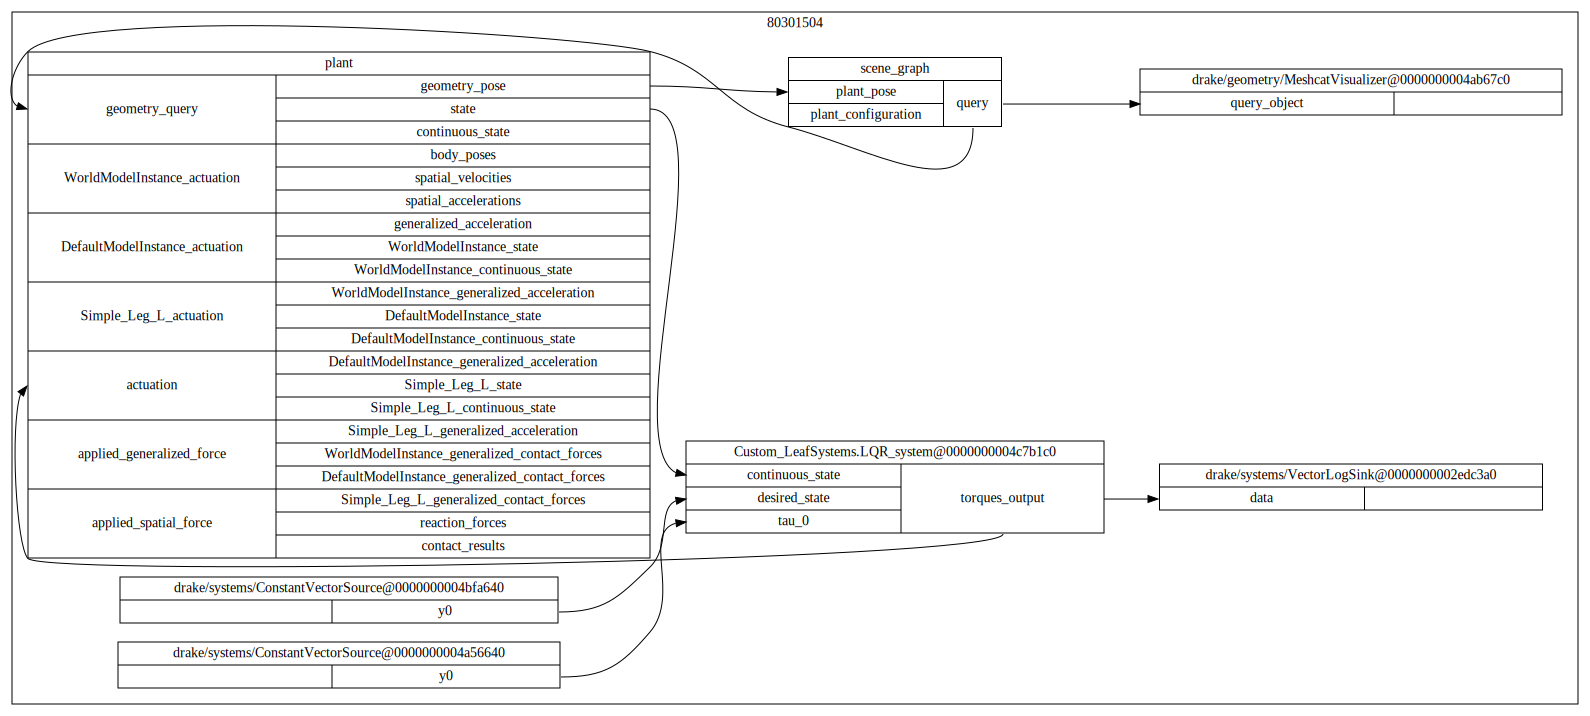

In [5]:
diagram = builder.Build()
display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

def PoseOptimization():
    context_diagram = diagram.CreateDefaultContext()
    plant_context_from_diagram = diagram.GetSubsystemContext(plant, context_diagram)

    sliders = MeshcatJointSliders(meshcat, plant, context_diagram)
    sliders.Run(vis, context_diagram)
    meshcat.DeleteAddedControls()
    meshcat.Delete()

# PoseOptimization()

In [6]:
# Set up a simulator to run this diagram

simulator = Simulator(diagram)
sim_context = simulator.get_mutable_context()

sim_context.SetTime(0.)

nr_poses = 1
eq_poses = np.tile(pos_test, (nr_poses, 1))
np.random.seed(5)
# rand_pose = 0.01 * np.random.randn(nr_poses, plant.num_positions())
poses = eq_poses # + rand_pose

vels = np.tile(np.zeros(plant.num_velocities()), (nr_poses, 1))

poses = np.hstack((poses, vels))

simulator.set_target_realtime_rate(0.0)
balanced = []

import time
time_sim = 50

for pose in tqdm(poses):

    unstable = False
    
    if time_step != 0.0:
        sim_context.SetDiscreteState(0, pose)
    else:
        sim_context.SetContinuousState(pose)
    
    try:
        # vis.StartRecording()
        # time.sleep(2)
        simulator.Initialize()
        simulator.AdvanceTo(sim_context.get_time() + time_sim)
    except TimeoutError:
        balanced.append([pose, "Not stable"])
        unstable = True

    # vis.StopRecording()
    if not unstable: balanced.append([pose, "stable"])

    sim_context.SetTime(0.0)

# vis.PublishRecording()

stable_poses = []
for i in range(len(balanced)): 
    if balanced[i][1] == "stable": stable_poses.append(balanced[i][0])

dev = np.array(stable_poses) - np.tile(np.hstack((pos_test, np.zeros(plant.num_velocities()))), (len(stable_poses), 1))

dev = np.diagonal(dev.dot(dev.T))
index_max_dev = np.argmax(dev)

print(stable_poses[index_max_dev])

if time_step != 0.0:
    sim_context.SetDiscreteState(0, stable_poses[index_max_dev])
else:
    sim_context.SetContinuousState(stable_poses[index_max_dev])

sim_context.SetTime(0.0)
simulator.Initialize()
vis.StartRecording()
simulator.AdvanceTo(sim_context.get_time() + time_sim)
vis.StopRecording()
vis.PublishRecording()

meshcat.DeleteAddedControls()

# sim_context.SetContinuousState(des_state)
# vis.StartRecording()
# simulator.AdvanceTo(4)
# vis.StopRecording()
# vis.PublishRecording()

# meshcat.DeleteAddedControls()

torque_data = logger_torque.FindLog(sim_context).data()
t = np.arange(0, len(torque_data[1]))

show = True

plt.plot(t, torque_data[0, :], label="Knee_L")
plt.plot(t, torque_data[4, :], label="Knee_R")
plt.legend()
plt.title("Knee torques")
plt.xlabel("Time step")
plt.ylabel("Torque [Nm]")
plt.tight_layout()

if show:
    plt.show()
else:
    plt.savefig("Figures/Double_Leg_Knee_Torques.pdf")
    plt.close()

# plt.plot(t, torque_data[1, :], label="Hip_pitch_L")
# plt.plot(t, torque_data[5, :], label="Hip_pitch_R")
# plt.legend()
# plt.title("Hip pitch torques")
# plt.xlabel("Time step")
# plt.ylabel("Torque [Nm]")
# plt.tight_layout()

# if show:
#     plt.show()
# else:
#     plt.savefig("Figures/Double_Leg_Hip_Pitch_Torques.pdf")
#     plt.close()

# plt.plot(t, torque_data[2, :], label="Hip_roll_L")
# plt.plot(t, torque_data[6, :], label="Hip_roll_R")
# plt.legend()
# plt.title("Hip roll torques")
# plt.xlabel("Time step")
# plt.ylabel("Torque [Nm]")
# plt.tight_layout()

# if show:
#     plt.show()
# else:
#     plt.savefig("Figures/Double_Leg_Hip_Roll_Torques.pdf")
#     plt.close()

# # TODO:


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


[ 0.36       -0.3091674  -1.16543749 -0.09653766  0.30368091  0.06
  0.64        0.01        0.45        0.05        0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


<ipython-input-6-c96423f282c0>:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


/usr/lib/python3.8/tkinter/__init__.py:814: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args)
/usr/lib/python3.8/tkinter/__init__.py:1892: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return self.func(*args)
